In [62]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import sys

Tamño de la image:  (240, 352)


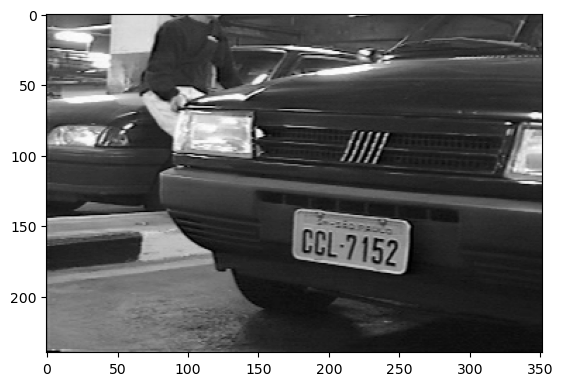

In [219]:
img1 = imageio.imread('../placa6.png')
print("Tamño de la image: ", img1.shape)
plt.imshow(img1, cmap="gray")
plt.show()

## Preprocesing:

source: 
- https://www.geeksforgeeks.org/detect-and-recognize-car-license-plate-from-a-video-in-real-time/
- https://pyimagesearch.com/2020/09/21/opencv-automatic-license-number-plate-recognition-anpr-with-python/


## 2. Preprocesamiento:
1.  Investigación del método “contorno-placa” propuesto en una imagen:
 - i. Prepara imagen en escala de grises
 -ii. Aplicar Filtro Gaussiano ( Eliminar ruido y suavizar la imagen)
 - iii. Aplicar Filtro Sobel Vertical X(Detectar bordes verticales)
 - iv. Aplicar Umbral OTSU(Para binarizar y segmentar imagen)
 - v. Aplicar Operación Closing( Para realzar la forma de la placa)
 - vi. Aplicar Operación Opening( Para eliminar puntos negros y realzar la forma de la placa)
 - vii. Obtener Contorno de la placa(Imagen Mascara):
    1. Opción 1: Dividir imagen en 2 y usar la parte inferior. Está opción fue la aplicada debido a que analizando las imágenes se encontró que el contorno de las imágenes se encontraron en la parte inferior de las imágenes procesadas.
    2. Opción 2: Uso del algoritmo moore, square tracing. Está opción aún está en proceso debido a tiempo de prueba y ajuste del algoritmo.
    
2. Creación de dataset:
 - i. Aplicamos el método “contorno-placa” para encontrar la imagen mascara de todas las imágenes originales.
 - ii. Aplicar Algoritmo Bounding Box para encontrar las coordenadas del contorno de la placa.
   1. Se aplicó técnicas estadísticas cómo media, outliers, para validar el valor del ancho(W - Width) y largo(H - Height) utilizado.
 - iii. Crear dataset de imágenes fondo.
 - iv. Crear dataset de imágenes placa.

In [239]:
# minimum area of the plate
min_area = 1000 
 
# maximum area of the plate
max_area = 10000 

def clean_plate(plate):

    thresh = cv2.adaptiveThreshold(plate,
                                   255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY,
                                   11, 2)
     
    contours, _ = cv2.findContours(thresh.copy(),
                                      cv2.RETR_EXTERNAL,
                                      cv2.CHAIN_APPROX_NONE)

    if contours:
        areas = [cv2.contourArea(c) for c in contours]
         
        # index of the largest contour in the area
        # array
        max_index = np.argmax(areas) 

        max_cnt = contours[max_index]
        max_cntArea = areas[max_index]
        x, y, w, h = cv2.boundingRect(max_cnt)
        rect = cv2.minAreaRect(max_cnt)
         
        if not ratioCheck(max_cntArea, plate.shape[1], plate.shape[0]):
            return plate, False, None
         
        return plate, True, [x, y, w, h]
     
    else:
        return plate, False, None

def preRatioCheck(area, width, height):
         
    min = min_area
    max = max_area
 
    ratioMin = 2
    ratioMax = 6
 
    ratio = float(width) / float(height)
     
    if (area < min or area > max) or (ratio < ratioMin or ratio > ratioMax):
        return False
     
    return True

def validateRatio(rect):
    (x, y), (width, height), rect_angle = rect
    
    if (width > height):
        angle = -rect_angle
    else:
        angle = 90 + rect_angle 
    if angle > 15:
        return False
     
    if (height == 0 or width == 0):
        return False 
    area = width * height
    print(preRatioCheck(area, width, height), "preRatioCheck") 
    if not preRatioCheck(area, width, height):
        return False
    else:
        return True
    
def check_plate(input_img, contour):
     
    min_rect = cv2.minAreaRect(contour)
    print(validateRatio(min_rect), "validateRatio")
    if validateRatio(min_rect):
        x, y, w, h = cv2.boundingRect(contour)
        after_validation_img = input_img[y:y + h, x:x + w]
        after_clean_plate_img, plateFound, coordinates = clean_plate(after_validation_img)
        print(plateFound, "")
        if plateFound:
            return after_clean_plate_img, plateFound, [x, y, w, h]   
    return None, None, None

def find_plates(input_img):
    plates = []
    char_on_plate = []
    corresponding_area = []
 
    after_preprocess = preprocess(input_img)
    possible_plate_contours = extract_contours(after_preprocess)
    print(len(possible_plate_contours))
    for cnts in possible_plate_contours:
        
        plate, plateFound, coordinates = check_plate(input_img, cnts)
        print(plateFound) 
        if plate is not None:
            plates.append(plate)
            char_on_plate.append(plateFound)
            corresponding_area.append(coordinates)
 
    if (len(plates) > 0):
        return plates, corresponding_area
     
    else:
        return None

In [238]:
plate_img, plat_coordinates = find_plates(img1)

7
True preRatioCheck
True validateRatio
True preRatioCheck
False 
None
False validateRatio
None
False validateRatio
None
False validateRatio
None
False validateRatio
None
False validateRatio
None
False validateRatio
None


TypeError: cannot unpack non-iterable NoneType object

In [240]:
plate_info[0], plat_coordinates[0]

(Array([[ 36,  36,  33, ...,  35,  34,  32],
        [ 35,  33,  31, ...,  45,  40,  37],
        [ 32,  32,  30, ...,  33,  33,  33],
        ...,
        [ 18,  13,  13, ..., 141, 159, 149],
        [ 23,  24,  22, ..., 138, 160, 149],
        [ 21,  23,  23, ..., 139, 163, 138]], dtype=uint8),
 [100, 131, 91, 38])

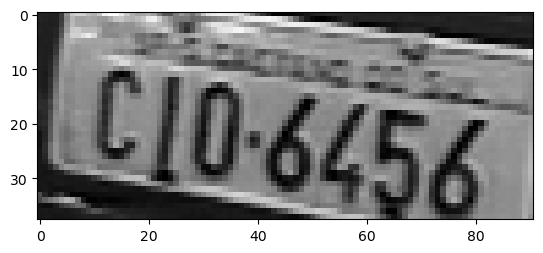

In [241]:
plt.imshow(plate_info[0], cmap="gray")
plt.show()

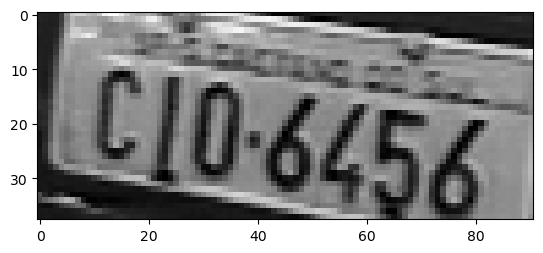

In [216]:
plt.imshow(img1[131:131+38,100:100 + 91], cmap="gray")
plt.show()